In [1]:
import datetime
import matplotlib.pyplot as plt
import numpy as np
import numpy.typing as npt
import pandas as pd
import scipy as sp

from typing import Literal

import warnings

warnings.filterwarnings("ignore")
np.random.seed(42)

## Libraries


In [2]:
def convert_df_sofr_to_df_rates(df_sofr: pd.DataFrame) -> pd.DataFrame:
    df_rates = df_sofr.iloc[:, [0, 1, -1]].copy()
    df_rates.columns = ["Tenor", "T", "rates"]
    return df_rates


def compute_discount_factor_from_zero_rate(
    zero_rate: float, time: float, method: Literal["compounding", "discrete"]
) -> float:
    """_summary_

    Args:
        zero_rate (float): zero interest rate in decimal
        time (float): time in year(s)
        method (str<compounding|discrete>): compute discount factor using either compounding or discrete methods

    Returns:
        float: discount factor
    """
    discount_factor_formula_dict = {
        "compounding": lambda r, t: np.exp(-r * t),
        "discrete": lambda r, t: 1 / (1 + r) ** t,
    }
    return discount_factor_formula_dict[method](zero_rate, time)


def compute_discount_factor_for_rates(df_rates: pd.DataFrame) -> pd.DataFrame:
    df_rates["discount_factor"] = df_rates.apply(
        lambda row: compute_discount_factor_from_zero_rate(
            row["rates"], row["T"], "compounding"
        ),
        axis=1,
    )
    return df_rates


class SwapProduct:
    def __init__(
        self,
        swap_type: Literal["payer", "receiver"],
        notional: float,
        starting_date: datetime.date,
        maturity: float,
        strike: float,
        float_frequency: float,
        fixed_frequency: float,
        df_discount_factor: pd.DataFrame,
    ):
        """A class to represent a swap product

        Args:
            notional (float): notional amount of swap
            starting_date (datetime.date): starting date of swap
            maturity (float): maturity of swap in year(s)
            strike (float): par rate of swap
            float_frequency (float): frequency of floating rate
            fixed_frequency (float): frequency of fixed rate
            df_discount_factor (pd.DataFrame): dataframe of discount factors
        """
        self.swap_type = swap_type
        self.notional = notional
        self.starting_date = starting_date
        self.maturity = maturity
        self.strike = strike
        self.float_frequency = float_frequency
        self.fixed_frequency = fixed_frequency
        self.df_discount_factor = df_discount_factor
        self.df_swap = pd.DataFrame()

        self.setup_df_swap()
        self.calculate_fixed_leg_cf()
        self.calculate_floating_leg_cf()

    def setup_df_swap(self):
        float_leg_payment_terms = np.arange(
            self.float_frequency,
            self.maturity + self.float_frequency,
            self.float_frequency,
        )
        fixed_leg_payment_terms = np.arange(
            self.fixed_frequency,
            self.maturity + self.fixed_frequency,
            self.fixed_frequency,
        )
        df_float_leg = pd.DataFrame(
            {
                "T": float_leg_payment_terms,
                "floating_cf": np.zeros(len(float_leg_payment_terms)),
            }
        )
        df_fixed_leg = pd.DataFrame(
            {
                "T": fixed_leg_payment_terms,
                "fixed_cf": np.zeros(len(fixed_leg_payment_terms)),
            }
        )
        self.df_swap = pd.merge(
            df_float_leg, df_fixed_leg, on="T", how="outer"
        ).sort_values(by="T", ascending=True)
        self.df_swap = pd.merge(
            self.df_discount_factor[["T", "discount_factor"]],
            self.df_swap,
            on="T",
            how="right",
        ).set_index("T")
        self.df_swap["discount_factor"] = (
            self.df_swap["discount_factor"].interpolate("index").values
        )

    def calculate_present_value(self) -> float:
        fixed_leg_pv = (
            self.df_swap["fixed_cf"] * self.df_swap["discount_factor"]
        ).sum()
        floating_leg_pv = self.notional * (1 - self.df_swap["discount_factor"].iloc[-1])
        npv = floating_leg_pv - fixed_leg_pv
        npv = npv if self.swap_type == "payer" else -npv
        return npv

    def calculate_fixed_leg_cf(self):
        self.df_swap.loc[self.df_swap["fixed_cf"].notna(), "fixed_cf"] = (
            self.notional * self.strike * self.fixed_frequency
        )

    def calculate_floating_leg_cf(self) -> float:
        pass


def compute_swap_pv(df_rates: pd.DataFrame, swap_data: dict) -> float:
    swap = SwapProduct(
        swap_data["type"],
        swap_data["notional"],
        swap_data["starting_date"],
        swap_data["maturity"],
        swap_data["strike"],
        swap_data["float_frequency"],
        swap_data["fixed_frequency"],
        compute_discount_factor_for_rates(df_rates),
    )
    return swap.calculate_present_value()


def compute_swap_init_val_and_pv_bips_change(
    df_rates: pd.DataFrame, swap_data: dict, bips: float
) -> (float, npt.NDArray):
    swap_pv_01 = []
    # Hard code the range of tenor for now
    for i in range(0, 11):
        df_rates_tmp = df_rates.copy()
        if i != 0:
            df_rates_tmp.loc[df_rates_tmp["T"] == i, "rates"] += bips
        swap_pv_01.append(compute_swap_pv(df_rates_tmp, swap_data))
    swap_pv_01 = np.array(swap_pv_01)
    swap_init_val = swap_pv_01[0]
    swap_pv_01 = (swap_pv_01 - swap_init_val)[1:] / bips
    return swap_init_val, swap_pv_01

In [3]:
def eigen_decomposition(samples: npt.NDArray) -> npt.NDArray:
    eigenvalues, eigenvectors = np.linalg.eig(samples)
    lamda = np.diag(eigenvalues)
    return eigenvectors @ np.sqrt(lamda)


class MonteCarloSimulation:
    def __init__(
        self,
        input_samples: npt.NDArray,
        decomposition_method: Literal["cholesky", "eigen"] = "cholesky",
    ):
        self.input_samples = input_samples
        self.decomposition_method = decomposition_method

    def generate_uniform_random_numbers_sample(self, d: int) -> npt.NDArray:
        sampler = sp.stats.qmc.Sobol(d, scramble=False)
        samples = sampler.random_base2(m=14)
        samples = np.delete(samples, 0, axis=0)
        return samples

    def simulate_samples(self):
        uniform_random_numbers_samples = self.generate_uniform_random_numbers_sample(
            np.shape(self.input_samples)[0]
        )
        normal_random_number_samples = sp.stats.norm.ppf(
            uniform_random_numbers_samples, 0, 1
        )
        input_samples_corr_coef = np.corrcoef(self.input_samples)
        input_samples_decomposition = self.decompose_samples(input_samples_corr_coef)

        normal_output_samples = (
            input_samples_decomposition @ normal_random_number_samples.T
        ).T

        output_samples = normal_output_samples * self.input_samples.std(
            axis=1, ddof=1
        ) + self.input_samples.mean(axis=1)
        return output_samples

    def decompose_samples(self, samples: npt.NDArray):
        decomposition_func = {
            "cholesky": lambda samples: np.linalg.cholesky(samples),
            "eigen": lambda samples: eigen_decomposition(samples),
        }

        return decomposition_func[self.decomposition_method](samples)

## Data Import & Common Parameters


In [4]:
file_directory = "./hist_data_updated.xlsm"
# Only take relevant rates tenor (1 - 10 years) for now
df_sofr = pd.read_excel(file_directory, sheet_name="SofrCurve")[6:16].reset_index(
    drop=True
)
df_aapl = pd.read_excel(file_directory, sheet_name="AAPL")
df_msft = pd.read_excel(file_directory, sheet_name="MSFT")
df_f = pd.read_excel(file_directory, sheet_name="F")
df_bac = pd.read_excel(file_directory, sheet_name="BAC")

bips = 0.01 / 100

## 1. VaR Parameters


In [5]:
var_parameters = {
    "significance_level": 0.05,  # in decimals
    "risk_horizon": 1,  # in days
    "reporting_currency": "USD",
    "current_date": datetime.date(2023, 10, 30),
}

## 2. Portfolio Identification


In [6]:
portfolio_dict = {
    "sofr_swap": [
        {
            "id": 1,
            "type": "payer",
            "notional": 100000000,
            "starting_date": datetime.date(2023, 10, 30),
            "maturity": 10,  # in years
            "strike": 0.042,  # in decimals
            "float_frequency": 1,  # in year
            "fixed_frequency": 1,  # in year
            "df_sofr": df_sofr,
            "pv_01": [],
            "current_value": 0,
        }
    ],
    "stock": [
        {
            "id": 1,
            "type": "long",
            "ticker": "AAPL",
            "notional": 1000000,
            "starting_date": datetime.date(2023, 10, 30),
            "df_stock": df_aapl,
        },
        {
            "id": 2,
            "type": "long",
            "ticker": "MSFT",
            "notional": 1000000,
            "starting_date": datetime.date(2023, 10, 30),
            "df_stock": df_msft,
        },
        {
            "id": 3,
            "type": "long",
            "ticker": "F",
            "notional": 1000000,
            "starting_date": datetime.date(2023, 10, 30),
            "df_stock": df_f,
        },
        {
            "id": 4,
            "type": "long",
            "ticker": "BAC",
            "notional": 1000000,
            "starting_date": datetime.date(2023, 10, 30),
            "df_stock": df_bac,
        },
    ],
}

In [7]:
df_rates = convert_df_sofr_to_df_rates(df_sofr)

for swap in portfolio_dict["sofr_swap"]:
    swap["current_value"], swap["pv_01"] = compute_swap_init_val_and_pv_bips_change(
        df_rates, swap, bips
    )

## 3. Risk Factors Identification


In [8]:
class RiskFactor:
    def __init__(self, id: str):
        self.id = id
        self.factor_changes = None

    def get_risk_factor_changes_func(
        self,
        method: Literal["absolute", "simple", "log"],
    ):
        risk_factor_changes_dict = {
            "absolute": lambda initial, final: final - initial,
            "simple": lambda initial, final: (final - initial) / initial,
            "log": lambda initial, final: np.log(final / initial),
        }
        return risk_factor_changes_dict[method]

    def derive_risk_factor_changes(
        self,
        method: Literal["absolute", "simple", "log"],
        initial_arr: float,
        final_arr: float,
    ):
        risk_factor_changes_func = self.get_risk_factor_changes_func(method)
        risk_factor_changes_func_v = np.vectorize(risk_factor_changes_func)
        self.factor_changes = risk_factor_changes_func_v(initial_arr, final_arr)


class RiskFactorRate(RiskFactor):
    def __init__(self, id: str, dates: npt.NDArray, rates: npt.NDArray):
        super().__init__(id)
        self.dates = dates
        self.rates = rates
        self.execute()

    def execute(self):
        self.derive_risk_factor_changes(
            "absolute",
            self.rates[:-1],
            self.rates[1:],
        )


class RiskFactorStock(RiskFactor):
    def __init__(self, id: str, dates: npt.NDArray, prices: npt.NDArray):
        super().__init__(id)
        self.dates = dates
        self.prices = prices
        self.execute()

    def execute(self):
        self.derive_risk_factor_changes(
            "simple",
            self.prices.values[:-1],
            self.prices.values[1:],
        )

In [9]:
risk_factors = []

for sofr_swap in portfolio_dict["sofr_swap"]:
    for index, row in sofr_swap["df_sofr"].iterrows():
        risk_factor = RiskFactorRate(
            row["T"], row.index[2:], row.values[2:]
        ).factor_changes
        risk_factors.append(risk_factor)

for stock in portfolio_dict["stock"]:
    df_stock = stock["df_stock"]
    risk_factor = RiskFactorStock(
        stock["ticker"], df_stock["Date"], df_stock["Adj Close"]
    ).factor_changes
    risk_factors.append(risk_factor)

risk_factors = np.array(risk_factors)

## VaR Computation


In [10]:
class ValueAtRisk:
    def __init__(
        self,
        significance_level: float,
        risk_horizon: float,
        risk_factors: npt.NDArray,
        asset_sensitivity: npt.NDArray,
    ):
        self.significance_level = significance_level
        self.risk_horizon = risk_horizon
        self.risk_factors = risk_factors
        self.asset_sensitivity = asset_sensitivity

        self.sample_returns = None
        self.VaR = None

    def plot_var(self, title: str, mean: float, variance: float):
        std_dev = np.sqrt(variance)

        max_val = np.max(np.abs(self.sample_returns))
        min_val = -max_val
        x = np.linspace(min_val, max_val, 10000)
        y = sp.stats.norm.pdf(x, mean, std_dev)

        fig, ax = plt.subplots(1, 1, figsize=(10, 6))
        plt.title(title)
        plt.hist(self.sample_returns, density=True, bins=50, alpha=0.5)
        plt.axvline(
            x=-self.VaR,
            color="r",
            label="Value-at-Risk at {significance}% significance level (abs): ${var:1,.0f}".format(
                significance=self.significance_level * 100, var=self.VaR
            ),
        )

        plt.plot(x, y, "k", linewidth=2)
        plt.legend(loc="upper right")
        ax.xaxis.set_major_formatter("${x:1,.0f}")
        plt.show()


class VaRComputationalApproach:
    def __init__(self, method: Literal["full_reeval", "risk_based"]):
        self.method = method

    def compute_sample_returns(
        self, risk_factors: npt.NDArray, asset_sensitivity: float
    ):
        var = 0
        if self.method == "full_reeval":
            return self.compute_sample_returns_full_reeval(
                risk_factors, asset_sensitivity
            )
        elif self.method == "risk_based":
            return self.compute_sample_returns_risk_based(
                risk_factors, asset_sensitivity
            )

    def compute_sample_returns_full_reeval(
        self, risk_factors: npt.NDArray, asset_sensitivity: float
    ):
        sample_returns = []
        # Rates
        rates_hist_changes = np.array(risk_factors)[0:10, :]
        swaps_return = []

        for rates_hist_chg in rates_hist_changes.T:
            swap_data = portfolio_dict["sofr_swap"][0]
            df_rates = convert_df_sofr_to_df_rates(swap_data["df_sofr"])
            df_rates["rates"] += rates_hist_chg

            swap_pnl = compute_swap_pv(df_rates, swap_data) - swap_data["current_value"]

            swaps_return.append(swap_pnl)
        sample_returns.append(swaps_return)

        # Stock
        for i in range(10, 14):
            risk_factor = risk_factors[i]
            sample_returns.append(asset_sensitivity[i] * risk_factor)
        return np.array(sample_returns).sum(axis=0)

    def compute_sample_returns_risk_based(
        self, risk_factors: npt.NDArray, asset_sensitivity: npt.NDArray
    ):
        return (asset_sensitivity[np.newaxis].T * risk_factors).sum(axis=0)

In [11]:
asset_sensitivity = []
asset_sensitivity.extend(portfolio_dict["sofr_swap"][0]["pv_01"])
asset_sensitivity.extend(list(map(lambda x: x["notional"], portfolio_dict["stock"])))
asset_sensitivity = np.array(asset_sensitivity)

In [12]:
asset_sensitivity

array([3.98600677e+06, 7.63179678e+06, 1.09930011e+07, 1.40665536e+07,
       1.68547510e+07, 1.93710561e+07, 2.16323359e+07, 2.36532276e+07,
       2.54477691e+07, 6.70595263e+08, 1.00000000e+06, 1.00000000e+06,
       1.00000000e+06, 1.00000000e+06])

### Parametric Model


In [13]:
class VaRParametric(ValueAtRisk):
    def __init__(
        self,
        significance_level: float,
        risk_horizon: float,
        risk_factors: npt.NDArray,
        asset_sensitivity: npt.NDArray,
    ):
        super().__init__(
            significance_level, risk_horizon, risk_factors, asset_sensitivity
        )
        self.sample_returns = self.compute_sample_returns()
        self.mean = self.compute_mean()
        self.variance = self.compute_variance()
        self.VaR = self.compute_VaR()

    def compute_sample_returns(self):
        return (self.asset_sensitivity[np.newaxis].T * self.risk_factors).sum(axis=0)

    def compute_VaR(self):
        return np.abs(
            self.mean
            + np.sqrt(self.variance) * sp.stats.norm.ppf(self.significance_level)
        )

    def plot_var(self):
        super().plot_var("Parametric VaR", self.mean, self.variance)

    def compute_mean(self):
        return (
            np.sum(self.asset_sensitivity @ np.mean(self.risk_factors, axis=1))
            * self.risk_horizon
        )

    def compute_variance(self):
        return (
            self.asset_sensitivity
            @ np.cov(self.risk_factors)
            @ self.asset_sensitivity.T
            * self.risk_horizon
        )

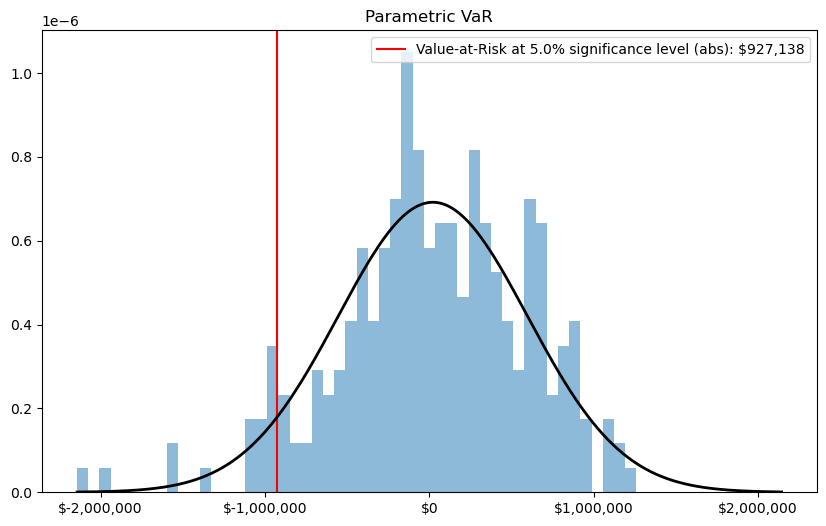

In [14]:
var_parametric = VaRParametric(
    var_parameters["significance_level"],
    var_parameters["risk_horizon"],
    risk_factors,
    asset_sensitivity,
)

var_parametric.plot_var()

### Monte-Carlo Model


In [15]:
class VaRMonteCarlo(ValueAtRisk):
    def __init__(
        self,
        significance_level: float,
        risk_horizon: float,
        risk_factors: npt.NDArray,
        asset_sensitivity: npt.NDArray,
        method: Literal["full_reeval", "risk_based"],
    ):
        super().__init__(
            significance_level, risk_horizon, risk_factors, asset_sensitivity
        )
        self.method = method
        self.risk_factors = risk_factors
        self.simulated_risk_factors = self.simulate_mc_risk_factors()
        self.sample_returns = self.compute_sample_returns()
        self.mean = self.compute_mean()
        self.variance = self.compute_variance()

        self.VaR = self.compute_VaR()

    def simulate_mc_risk_factors(self):
        mc_sample = (
            MonteCarloSimulation(self.risk_factors, "eigen").simulate_samples().T
        )
        return mc_sample

    def compute_sample_returns(self):
        return VaRComputationalApproach(self.method).compute_sample_returns(
            self.simulated_risk_factors, self.asset_sensitivity
        )

    def compute_mean(self):
        return np.mean(self.sample_returns)

    def compute_variance(self):
        return np.var(self.sample_returns)

    def compute_VaR(self):
        return np.abs(
            np.percentile(
                self.sample_returns,
                self.significance_level * 100,
                interpolation="linear",
            )
        )

    def plot_var(self):
        method_dict = {"full_reeval": "Full Revaluation", "risk_based": "Risk Based"}
        title = "Monte Carlo VaR ({})".format(method_dict[self.method])
        super().plot_var(title, self.mean, self.variance)

#### Full Re-evaluation Approach


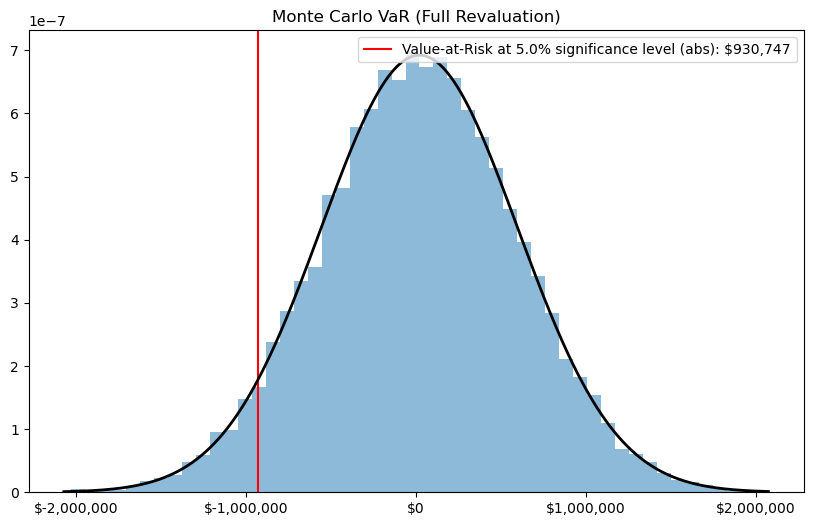

In [16]:
var_monte_carlo_full_reeval = VaRMonteCarlo(
    var_parameters["significance_level"],
    var_parameters["risk_horizon"],
    risk_factors,
    asset_sensitivity,
    "full_reeval",
)

var_monte_carlo_full_reeval.plot_var()

#### Risk-based Approach


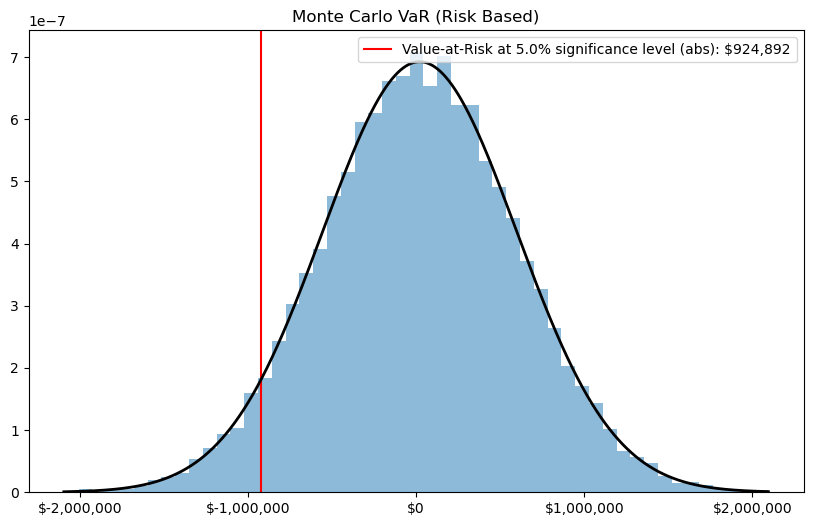

In [17]:
var_monte_carlo_risk = VaRMonteCarlo(
    var_parameters["significance_level"],
    var_parameters["risk_horizon"],
    risk_factors,
    asset_sensitivity,
    "risk_based",
)

var_monte_carlo_risk.plot_var()

### Historical Model


In [18]:
class VaRHistorical(ValueAtRisk):
    def __init__(
        self,
        significance_level: float,
        risk_horizon: float,
        risk_factors: npt.NDArray,
        asset_sensitivity: npt.NDArray,
        method: Literal["full_reeval", "risk_based"],
    ):
        super().__init__(
            significance_level, risk_horizon, risk_factors, asset_sensitivity
        )
        self.method = method
        self.sample_returns = self.compute_sample_returns()
        self.mean = self.compute_mean()
        self.variance = self.compute_variance()

        self.VaR = self.compute_VaR()

    def compute_sample_returns(self):
        return VaRComputationalApproach(self.method).compute_sample_returns(
            self.risk_factors, self.asset_sensitivity
        )

    def compute_mean(self):
        return np.mean(self.sample_returns)

    def compute_variance(self):
        return np.var(self.sample_returns)

    def compute_VaR(self):
        return np.abs(
            np.percentile(
                self.sample_returns,
                self.significance_level * 100,
                interpolation="linear",
            )
        )

    def plot_var(self):
        method_dict = {"full_reeval": "Full Revaluation", "risk_based": "Risk Based"}
        title = "Historical VaR ({})".format(method_dict[self.method])
        super().plot_var(title, self.mean, self.variance)

#### Full Revaluation Approach


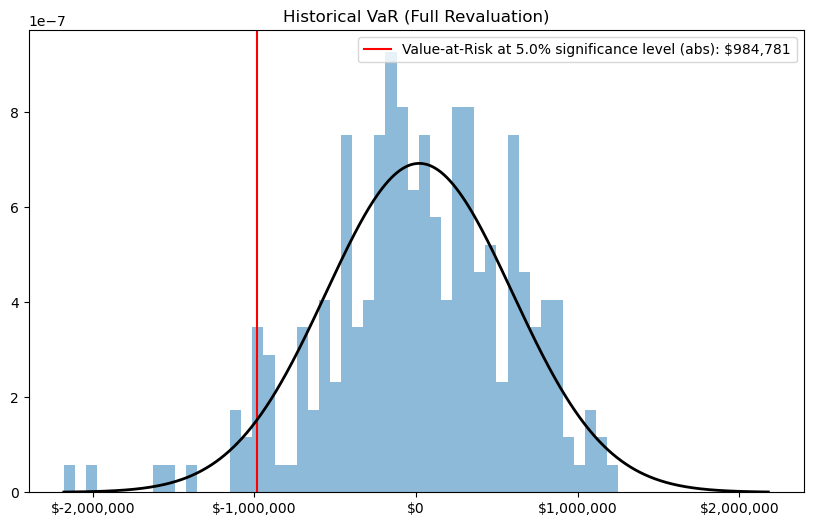

In [19]:
var_historical_full_reeval = VaRHistorical(
    var_parameters["significance_level"],
    var_parameters["risk_horizon"],
    risk_factors,
    asset_sensitivity,
    "full_reeval",
)

var_historical_full_reeval.plot_var()

#### Risk-based Approach


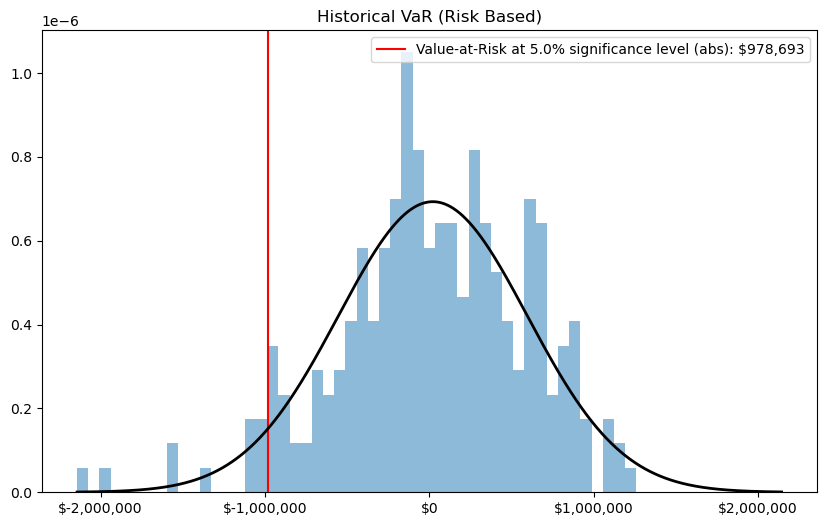

In [20]:
var_historical_risk = VaRHistorical(
    var_parameters["significance_level"],
    var_parameters["risk_horizon"],
    risk_factors,
    asset_sensitivity,
    "risk_based",
)

var_historical_risk.plot_var()

## Final Results


In [21]:
result_dict = {
    "VaR Methods": [
        "Parametric",
        "MC Full Revaluation",
        "MC Risk-Based",
        "Historical Full Revaluation",
        "Historical Risk-Based",
    ],
    "VaR": [
        var_parametric.VaR,
        var_monte_carlo_full_reeval.VaR,
        var_monte_carlo_risk.VaR,
        var_historical_full_reeval.VaR,
        var_historical_risk.VaR,
    ],
}

df_results = pd.DataFrame(result_dict)
pd.set_option("float_format", "{:f}".format)
df_results

,VaR Methods,VaR
0,Parametric,927138.226293
1,MC Full Revaluation,930747.398783
2,MC Risk-Based,924891.520081
3,Historical Full Revaluation,984781.392029
4,Historical Risk-Based,978693.269347
